In [18]:
## Import Utilities


import os, itertools 
import time
import random, shutil  # shutil is a utility for file system operations
import numpy as np 
import pandas as pd
from random import shuffle
 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.preprocessing import StandardScaler

In [19]:
import os



In [20]:
## Load and process the data
INPUT_DATA_PATH = "./train/raw/LithiumIonBatteryDegredation/Battery_dataset.csv"

input_param_cols = ['chI', 'chV', 'chT', 'disI', 'disV', 'disT']
validate_param_col = 'SOH'


df = pd.read_csv(INPUT_DATA_PATH)

input_params = df[input_param_cols].values
validate_params = df[validate_param_col].values

# Normalize 
scaler = StandardScaler()
input_params = scaler.fit_transform(input_params)
# move to be 0-1 instead of 0-100
validate_params = validate_params / 100.0

In [22]:
## Separate variables
from tcn import TCN

# Reshape for TCN: (N, 6 timesteps, 1 feature)
input_params_3d = input_params.reshape((input_params.shape[0], 6, 1))

# 1. First split: training vs temp (temp will be split into val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    input_params, validate_params,
    test_size=0.2, shuffle=True, random_state=42
)

# 2. Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, shuffle=True, random_state=42
)

# 3. Reshape for TCN
X_train = X_train.reshape((X_train.shape[0], 6, 1))
X_val   = X_val.reshape((X_val.shape[0], 6, 1))
X_test  = X_test.reshape((X_test.shape[0], 6, 1))

In [23]:
## Build TCN
from tcn import TCN

model = Sequential([
    TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8],
        dropout_rate=0.1,
        return_sequences=False,
        activation='relu',
        input_shape=(6, 1)   # <-- REQUIRED
    ),
    Dense(64, activation="relu"),
    Dense(1)
])

/home/seth/tf-env/lib/python3.12/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


In [24]:
## compile model
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_3 (TCN)                     │ (None, 64)             │        86,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,073 (355.75 KB)

 Trainable params: 91,073 (355.75 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
## Train Model
from tcn import TCN



history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.9640 - mae: 0.7566 - val_loss: 0.2003 - val_mae: 0.3637
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3228 - mae: 0.4477 - val_loss: 0.1127 - val_mae: 0.2857
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1884 - mae: 0.3465 - val_loss: 0.1200 - val_mae: 0.2930
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1538 - mae: 0.3178 - val_loss: 0.0970 - val_mae: 0.2561
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1292 - mae: 0.2868 - val_loss: 0.0806 - val_mae: 0.2325
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1072 - mae: 0.2536 - val_loss: 0.0784 - val_mae: 0.2330
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1033 - mae: 0.2579 - val_loss: 0.0791 - val_mae: 0.2323
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1001 - mae: 0.2540 - val_loss: 0.0778 - val_mae: 0.2286
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0962 - mae:

In [26]:
## Compare Accuracy
X_test = X_test.reshape((X_test.shape[0], 6, 1))


test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0337 - mae: 0.1623
Test MSE: 0.033716943114995956
Test MAE: 0.1623176783323288


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
RMSE: 0.18362173153870512
R² score: -0.21793193039165204


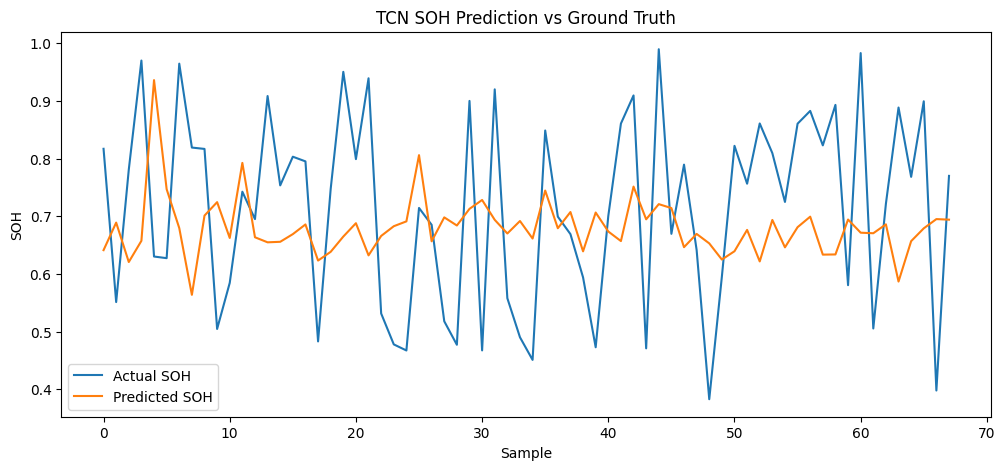

In [27]:
## Test / Evaluate
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² score:", r2)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual SOH')
plt.plot(y_pred, label='Predicted SOH')
plt.legend()
plt.xlabel("Sample")
plt.ylabel("SOH")
plt.title("TCN SOH Prediction vs Ground Truth")
plt.show()